# Import Stuffs

In [1]:
from transformers import AutoModelForMaskedLM, AutoTokenizer, BertTokenizer, AutoModel
from transformers import FillMaskPipeline
import requests
import pandas as pd
import numpy as np
import torch
from glob import glob
import json

torch.__version__

'1.8.1+cu111'

In [2]:
from sentence_transformers import SentenceTransformer, models

# Text preprocessing

In [3]:
import re
import emoji
from soynlp.normalizer import repeat_normalize

emojis = ''.join(emoji.UNICODE_EMOJI.keys())
pattern = re.compile(f'[^ .,?!/@$%~％·∼()\x00-\x7Fㄱ-ㅣ가-힣{emojis}]+')
url_pattern = re.compile(
    r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)')
rt_pattern = re.compile(r'@.+')

def clean(x):
    x = pattern.sub(' ', x)
    x = url_pattern.sub('', x)
    x = rt_pattern.sub('', x)
    if x.startswith('RT'):
        x = x[2:]
    x = x.strip()
    x = repeat_normalize(x, num_repeats=2)
    return x

# Twitter API

In [4]:
def get_tweets(q='오드트유'):
    pat = re.compile(q)
    
    if files := [i for i in glob('./data/*/*.json') if q in i]:
        res = []
        for i in files:
            res += json.load(open(i))
        original = [k for k in {clean(i) for i in res} if len(pat.findall(k)) == 1 and len(k) > 20]
        masked = [k.replace(q, '[MASK]') for k in original]
        return {
            'original': original,
            'masked': masked,
        }
    else:
        r = requests.get('https://api.twitter.com/1.1/search/tweets.json', headers={
            'Authorization': 'TWITER_TOKEN',
        }, params={
            'q': f'"{q}"',
            'count': 100,
            'include_entities': False,
        })
        original = [k for k in {clean(i['text']) for i in r.json()['statuses']} if len(pat.findall(k)) == 1 and len(k) > 20]
        masked = [k.replace(q, '[MASK]') for k in original]
        return {
            'original': original,
            'masked': masked
        }

# Get Contextual Token Representation from Sentence vectors

- Simply forward!

In [5]:
kcbert_sbert = SentenceTransformer('beomi/kcbert-base')

In [6]:
def get_contextualized_vector(q):
    tensors = []
    for i in get_tweets(q):
        tensors.append(kcbert_sbert.encode(i))
    token_tensor = np.mean(tensors, axis=0)
    return token_tensor

In [7]:
get_contextualized_vector('오드트유')

array([-3.52659702e-01,  6.07707143e-01,  8.62607658e-01,  7.07679212e-01,
       -1.98885754e-01,  7.70761490e-01,  3.15645128e-01,  5.84830225e-01,
       -9.33232605e-02,  1.24927783e+00, -2.27306560e-01,  2.46055320e-01,
        4.08244044e-01,  1.58681162e-02, -7.56632447e-01, -9.51309130e-03,
       -4.40158665e-01,  1.57900974e-01, -1.02627903e-01,  7.84245729e-02,
        2.98608661e-01,  3.13940376e-01,  4.71558303e-01, -3.57546389e-01,
       -1.03733882e-01, -4.02733982e-02,  1.21606641e-01, -6.38414323e-01,
       -5.41036427e-01,  2.60281980e-01, -1.20465066e-02,  1.90049425e-01,
        8.85946751e-01, -3.97475213e-01, -5.11408925e-01,  7.79309496e-02,
       -4.92492557e-01, -1.75016746e-01, -5.69120646e-02,  3.44267368e-01,
        4.67114478e-01, -2.76956588e-01,  1.64658159e-01,  4.53068703e-01,
       -3.61885130e-03, -7.01000392e-01,  7.36353278e-01,  5.86847305e-01,
        4.26882207e-01,  1.86776519e-02, -3.41471523e-01, -4.64688003e-01,
       -6.71194121e-02, -

# Create neologism-aware Sentence Vectors

1. Create Sentence Vector from BERT LM with [UNK] replaced sentence
2. Replace [UNK] location vector with previously acquired 768 tensor
3. MEAN Pooling!

In [8]:
from collections import defaultdict

In [47]:
def get_neologism_aware_sentence_bert_representation(sentence, model, tokenizer, extended_vectors={}):
    unk_tensors = []
    used_extend_tokens = defaultdict(int) # defaults to 0 
    for i in extended_vectors.keys():
        if i in tokenizer.vocab:
            continue # Ignore pre-esisting vocab
        used_extend_tokens[i] += 1
        sentence = sentence.replace(i, '[UNK]') # Extended vocab to UNK, to prevent irrlevent representation.

    unk_idx = [idx for idx, i in enumerate(tokenizer.encode(sentence)) if i == 1]
    encoded = kcbert_tokenizer(sentence, return_tensors='pt')
    unk_tensor = model(**encoded)
    final_layer_tensor = unk_tensor.last_hidden_state[0]

    for idx, vocab in zip(unk_idx, used_extend_tokens):
        final_layer_tensor[idx] = torch.FloatTensor(extended_vectors[vocab])
        unk_tensors.append(torch.mean(final_layer_tensor, axis=0))
    try:
        token_tensor_all = torch.mean(final_layer_tensor, axis=0)
        print(token_tensor_all.size())
    except Exception as e:
        print(e)
        return 
    return token_tensor_all

In [48]:
from sklearn.metrics.pairwise import cosine_similarity

def get_similarity_sampled_tweets(query, model, tokenizer, extended_vectors={}):
    np.random.seed(42)    
    sampled_tweets = get_tweets(query)['original']
    if len(sampled_tweets) > 20:
        sampled_tweets = np.random.choice(sampled_tweets, 20, replace=False)
    
    encoded_sampled_tweets = []
    for x in sampled_tweets:
        sbert_reps = get_neologism_aware_sentence_bert_representation(x, model, tokenizer, extended_vectors)
        if sbert_reps is not None:
            encoded_sampled_tweets.append(
                sbert_reps.detach().numpy()
            )
    
    encoded_sampled_tweets = [i for i in encoded_sampled_tweets if i.any()]
    
    sims_1 = []
    for i in encoded_sampled_tweets:
        for j in encoded_sampled_tweets:
            # print(cosine_similarity([i], [j]))
            if list(i) != list(j):
                sims_1.append(cosine_similarity([i], [j])[0][0])
    return np.mean(sims_1)

# Evaluation

## 1. Get extend vocab

In [44]:
new_vocabs = list({
    i.split('/')[-1].split()[0].replace('.json', '') 
    for i in glob('./data/*/*.json') if len(i.split('/')[-1].split()) == 1
})
new_vocabs

['경멸신한',
 '경멸하나',
 '사법연수원',
 '물고기들',
 '딥상어동',
 '무사만루',
 '불우이웃',
 '개인그림',
 '연성문장',
 '아이돌등판',
 '전과목A',
 '일어낫다',
 '수련언니',
 '자컾연성',
 '모닝커피',
 '헬로헬로',
 '드레이코',
 '수지서현',
 '디저트39',
 '기립박수',
 '안경에이스',
 '쫀아에용',
 '생일너무너무',
 '자빱티비',
 '동물농장',
 '자빱사단',
 '로또사서',
 '생일해시',
 '원더케이',
 '불로장생',
 '느낌표느낌표',
 '뉴스원샷',
 '자이언츠',
 '아웃카운트',
 '헤럴드POP',
 '가정했을때',
 '기습공격',
 '총공총공',
 '박지훈X',
 '대면팬싸',
 '군수송기',
 '배경화면',
 '맛집여행',
 '취업준비',
 '판타블렛',
 '반달모양',
 '푸른비늘',
 '투르크메니스탄',
 '섬온화님',
 '펜트하우스',
 '스타뉴스',
 '젠더퀴어',
 '스물두번째생일',
 '취향겹침표',
 '뮤직뱅크',
 '파트분배',
 '심야영화',
 '페인킬러',
 '연습영상',
 '신규확진',
 '아쿠아리움',
 '제이굿즈',
 '전공공부',
 '강다니엘',
 '감방생활',
 '기레기들',
 '셀카듀스',
 '북극바다',
 '로드스터',
 '라플라스',
 '이글읽고난다음',
 '철인3종경기',
 '프리허그',
 '시스젠더',
 '사운드트랙',
 '다크몬스터',
 '바다동물',
 '안무영상']

In [45]:
df = pd.DataFrame(new_vocabs, columns=['text'])
df.head()

,text
0,경멸신한
1,경멸하나
2,사법연수원
3,물고기들
4,딥상어동


## 2. Get contextual representation from PLM

- Retrieve contexual representation from PLM(Kcbert-base)

In [31]:
kcbert_model = AutoModel.from_pretrained('beomi/kcbert-base')
kcbert_tokenizer = AutoTokenizer.from_pretrained('beomi/kcbert-base')

Some weights of the model checkpoint at beomi/kcbert-base were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [32]:
kcbert_tokenizer.vocab['[UNK]'] # UNK의 id

1

In [33]:
%%time
extended_vectors = {
    vocab: get_contextualized_vector(vocab)
    for vocab in new_vocabs
}

CPU times: user 3.91 s, sys: 35.8 ms, total: 3.94 s
Wall time: 4.05 s


In [34]:
len(extended_vectors)

78

In [35]:
get_similarity_sampled_tweets(
        '생일해시', kcbert_model, kcbert_tokenizer, extended_vectors=extended_vectors)

0.52079016

In [36]:
from tqdm.auto import tqdm
tqdm.pandas()

In [37]:
df['evergreen'] = df['text'].progress_map(
    lambda x: get_similarity_sampled_tweets(
        x, kcbert_model, kcbert_tokenizer, extended_vectors=extended_vectors)) # with Extended vector

  0%|          | 0/78 [00:00<?, ?it/s]

stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList


/home/jovyan/anaconda3/envs/evergreenbert/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jovyan/anaconda3/envs/evergreenbert/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList


/home/jovyan/anaconda3/envs/evergreenbert/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jovyan/anaconda3/envs/evergreenbert/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


  0%|          | 0/78 [00:00<?, ?it/s]

stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList


/home/jovyan/anaconda3/envs/evergreenbert/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jovyan/anaconda3/envs/evergreenbert/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
s

stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
s

stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
s

stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
s

stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
s

stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
s

stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
stack expects a non-empty TensorList
s

In [49]:
df['kcbert'] = df['text'].progress_map(
    lambda x: get_similarity_sampled_tweets(
        x, kcbert_model, kcbert_tokenizer))

  0%|          | 0/78 [00:00<?, ?it/s]

torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size

torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size

torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size

torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size

In [51]:
df.head()

,text,kcbert
0,경멸신한,0.824325
1,경멸하나,0.666412
2,사법연수원,0.624321
3,물고기들,0.618841
4,딥상어동,0.589294


In [38]:
# df_idx = df.sort_values('evergreen').reset_index().drop('index', axis=1).reset_index()
# df_idx.head()

,index,text,evergreen,kcbert
0,0,심야영화,0.462578,NaN
1,1,수련언니,0.470112,NaN
2,2,펜트하우스,0.483859,NaN
3,3,연습영상,0.484059,NaN
4,4,자이언츠,0.485346,NaN


In [55]:
df_a = pd.merge(df_idx.drop('kcbert', axis=1), df, on='text')

In [57]:
df_a

,index,text,evergreen,kcbert
0,0,심야영화,0.462578,0.497058
1,1,수련언니,0.470112,0.533761
2,2,펜트하우스,0.483859,0.577261
3,3,연습영상,0.484059,0.541649
4,4,자이언츠,0.485346,0.530694
...,...,...,...,...
73,73,맛집여행,0.915463,0.925608
74,74,스물두번째생일,0.928301,0.933986
75,75,로또사서,0.977395,0.982453
76,76,강다니엘,NaN,0.571334


In [59]:
df_a[['text', 'evergreen', 'kcbert']].to_csv('./sentence.csv')

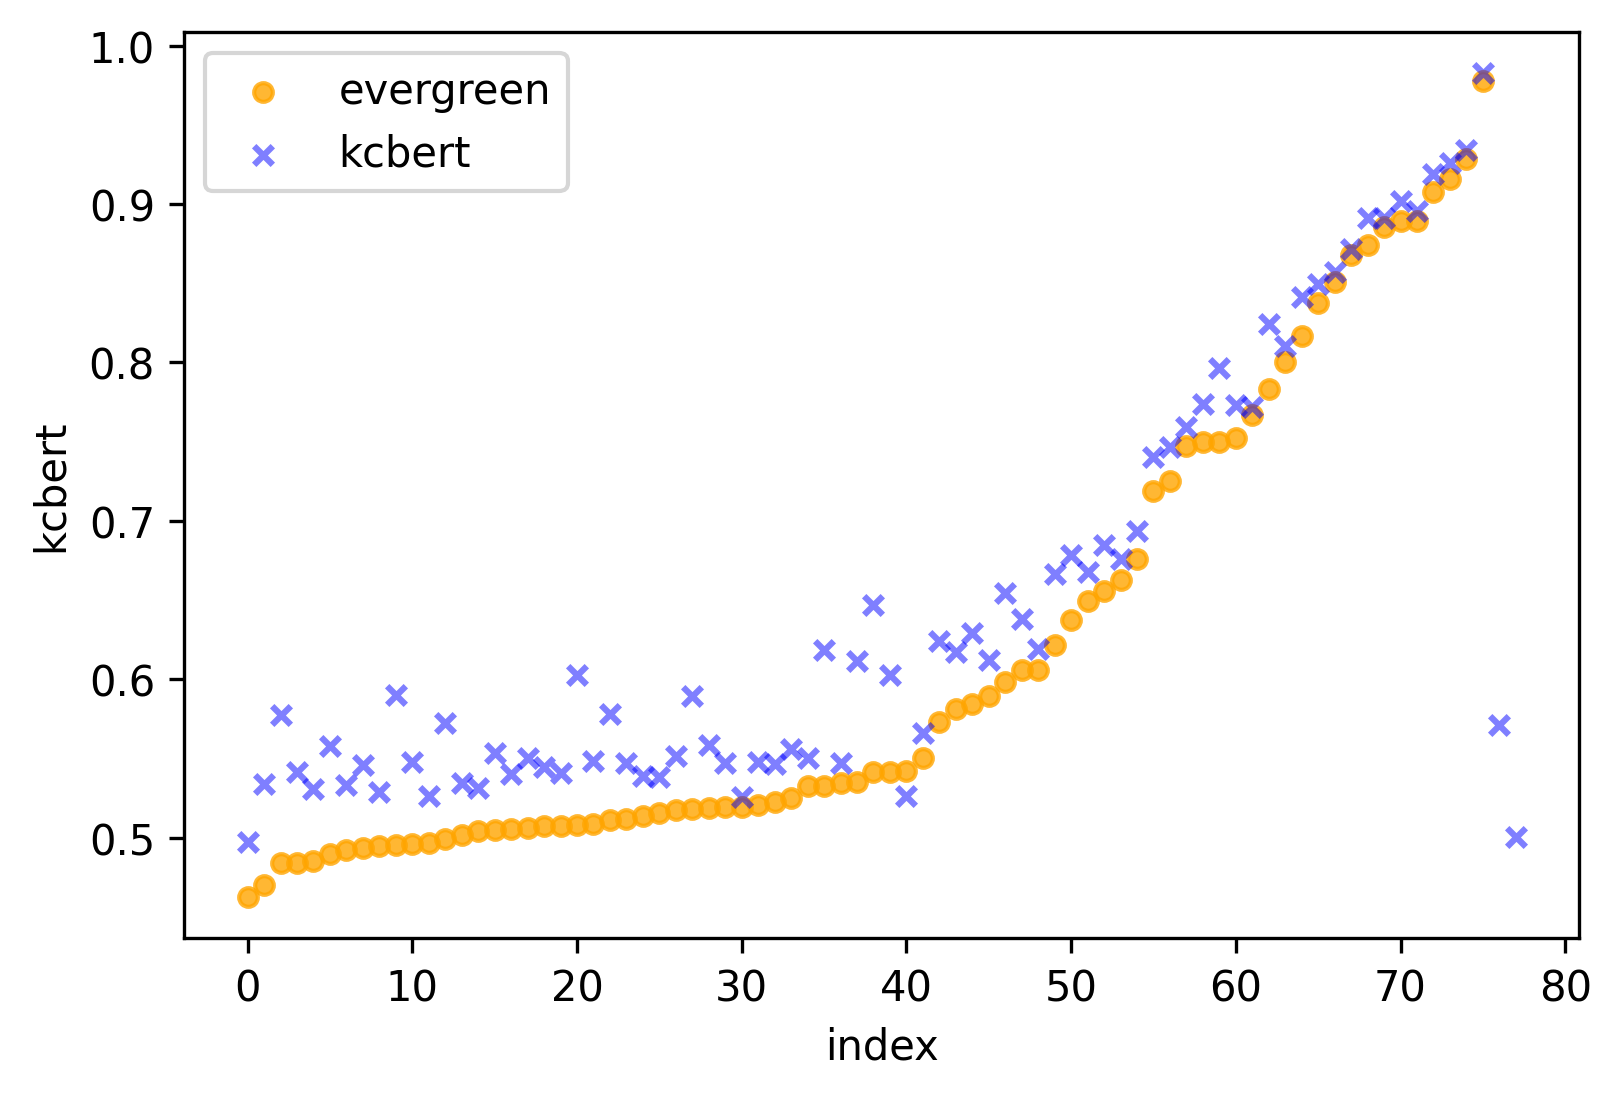

In [58]:
import matplotlib.pylab as plt
plt.rcParams["figure.dpi"] = 300

ax = df_a.plot(kind='scatter', x='index', y='evergreen', color='orange', alpha=0.8)
df_a.plot(kind='scatter', x='index', y='kcbert', color='blue',  alpha=0.5, ax=ax, marker='x')
ax.legend(['evergreen', 'kcbert'])